<a href="https://colab.research.google.com/github/tien-tran0906/A.I/blob/main/RESNET_50_Transfer_learning_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
import os
import shutil
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
tf.__version__

'2.15.0'

# LOADING IMAGES

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# allow using gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
# Specify the folder path
folder_path = "/content/drive/MyDrive/Colab datasets/RICE/Basmati"

# Initialize a counter
jpg_count = 0

# Loop through all files in the folder
for filename in os.listdir(folder_path):
  # Check if file ends with .jpg
  if filename.endswith(".jpg"):
    jpg_count += 1

# Print out the number of JPGs
print(f"Number of Basmati rice images: {jpg_count}")

Number of Basmati rice images: 180


In [5]:
# Specify the folder path
folder_path = "/content/drive/MyDrive/Colab datasets/RICE/Jasmine"

# Initialize a counter
jpg_count = 0

# Loop through all files in the folder
for filename in os.listdir(folder_path):
  # Check if file ends with .jpg
  if filename.endswith(".jpg"):
    jpg_count += 1

# Print out the number of JPGs
print(f"Number of Jasmine rice images: {jpg_count}")

Number of Jasmine rice images: 180


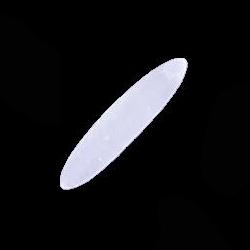

In [6]:
tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab datasets/RICE/Basmati/basmati (9794).jpg')

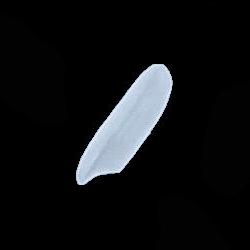

In [7]:
tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab datasets/RICE/Jasmine/Jasmine (9834).jpg')

# TRAIN TEST SPLIT

In [8]:
# COPY from the original folder
# basmati
source_dir = "/content/drive/MyDrive/Colab datasets/RICE/Basmati"
dest_dir1 = "/content/Basmati"

if not os.path.exists(dest_dir1):
    os.makedirs(dest_dir1)

    for file_name in os.listdir(source_dir):
        if file_name.endswith(".jpg"):
            source_file = os.path.join(source_dir, file_name)
            dest_file = os.path.join(dest_dir1, file_name)
            shutil.copy(source_file, dest_file)

# jasmine
source_dir = "/content/drive/MyDrive/Colab datasets/RICE/Jasmine"
dest_dir2 = "/content/Jasmine"

if not os.path.exists(dest_dir2):
    os.makedirs(dest_dir2)

    for file_name in os.listdir(source_dir):
        if file_name.endswith(".jpg"):
            source_file = os.path.join(source_dir, file_name)
            dest_file = os.path.join(dest_dir2, file_name)
            shutil.copy(source_file, dest_file)

# Create the Jasmine folder
jasmine = "/content/Jasmine"
if not os.path.exists(jasmine):
    os.makedirs(jasmine)

# Create the Basmati folder
basmati = "/content/Basmati"
if not os.path.exists(basmati):
    os.makedirs(basmati)

# Create test_set folder
test_set_path = "/content/test_set"
if not os.path.exists(test_set_path):
    os.makedirs(test_set_path)

# Create train_set folder
train_set_path = "/content/train_set"
if not os.path.exists(train_set_path):
    os.makedirs(train_set_path)

# Folders in test_set folder
test_jasmine = '/content/test_set/jasmine_test'
if not os.path.exists(test_jasmine):
    os.makedirs(test_jasmine)

test_basmati = '/content/test_set/basmati_test'
if not os.path.exists(test_basmati):
    os.makedirs(test_basmati)

# Folders in train_set folder
train_jasmine = '/content/train_set/jasmine_train'
if not os.path.exists(train_jasmine):
    os.makedirs(train_jasmine)

train_basmati = '/content/train_set/basmati_train'
if not os.path.exists(train_basmati):
    os.makedirs(train_basmati)

print("Created folders:")
print("- "+dest_dir1)
print("- "+dest_dir2)
print("- "+test_set_path)
print("- "+train_set_path)
print("- "+test_jasmine)
print("- "+test_basmati)
print("- "+train_jasmine)
print("- "+train_basmati)

Created folders:
- /content/Basmati
- /content/Jasmine
- /content/test_set
- /content/train_set
- /content/test_set/jasmine_test
- /content/test_set/basmati_test
- /content/train_set/jasmine_train
- /content/train_set/basmati_train


In [9]:
import random

folder = "/content/Jasmine"
train_folder = "/content/train_set/jasmine_train"
test_folder = "/content/test_set/jasmine_test"

image_files = os.listdir(folder)
random.shuffle(image_files)

total_files = len(image_files)
train_percentage = 0.8
train_num = int(total_files * train_percentage)

for i, file in enumerate(image_files):
    src_path = os.path.join(folder, file)
    if i < train_num:
        dst_path = os.path.join(train_folder, file)
    else:
        dst_path = os.path.join(test_folder, file)

    shutil.copy(src_path, dst_path)

print("Train and test split Jasmine rice complete!")


Train and test split Jasmine rice complete!


In [10]:
folder = "/content/Basmati"
train_folder = "/content/train_set/basmati_train"
test_folder = "/content/test_set/basmati_test"

image_files = os.listdir(folder)
random.shuffle(image_files)

total_files = len(image_files)
train_percentage = 0.8
train_num = int(total_files * train_percentage)

for i, file in enumerate(image_files):
    src_path = os.path.join(folder, file)
    if i < train_num:
        dst_path = os.path.join(train_folder, file)
    else:
        dst_path = os.path.join(test_folder, file)

    shutil.copy(src_path, dst_path)

print("Train and test split Basmati rice complete!")


Train and test split Basmati rice complete!


# DATA AUGMENTATION

In [11]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/train_set',
                                                       target_size = (256,256),
                                                       batch_size=8,
                                                       class_mode = 'categorical',
                                                       shuffle=True)

Found 288 images belonging to 2 classes.


In [12]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [13]:
train_dataset.class_indices

{'basmati_train': 0, 'jasmine_train': 1}

In [14]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/test_set',
                                                  target_size = (256,256),
                                                  batch_size=1,
                                                  class_mode = 'categorical',
                                                  shuffle=False)

Found 72 images belonging to 2 classes.


# IMPLEMENT TRANSFER LEARNING (RESNET)

In [15]:
base_model = tf.keras.applications.ResNet50(weights='imagenet',
                                            include_top=False, # use our custom dense layers
                                            input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 0s 0us/step


In [16]:
base_model.summary()  # no dense layer

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [17]:
len(base_model.layers)

175

In [18]:
for layer in base_model.layers:
  print(layer, layer.trainable) # see how many layers are trainable
  # Batch Norm is to adjusts the output of each neuron in a layer to have similar mean and variance.

<keras.src.engine.input_layer.InputLayer object at 0x78bc6b1fa0e0> True
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x78bc6ada46d0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78bc6b1fa0b0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x78bc6ada4ee0> True
<keras.src.layers.core.activation.Activation object at 0x78bc6ada5f60> True
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x78bc6ada6500> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78bc6ada7490> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78bc6ada73d0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x78bc6a1954e0> True
<keras.src.layers.core.activation.Activation object at 0x78bc6a1972e0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78bc6a196f50> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 

In [19]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
for layer in base_model.layers:
  print(layer, layer.trainable)  # freeze these layers

# CREATE CUSTOM DENSE LAYER (for classification)

In [21]:
# get the last layer of the model to connect to the dense layer
base_model.output # the last layer

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [22]:
head_model = base_model.output  # input layer
head_model = GlobalAveragePooling2D()(head_model) # convert to a vector
# (2048+2) / 2 = 1025
head_model = Dense(units=1025, activation='relu')(head_model)  # connect the dense layer to input
head_model = Dropout(rate = 0.2)(head_model)  # prevent overfitting

head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

# BUILD AND TRAIN

In [23]:
# connect both models
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [24]:
network = Model(inputs=base_model.input, outputs=head_model)

In [25]:
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [27]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
36/36 [==============================] - 16s 174ms/step - loss: 1.1911 - accuracy: 0.5903
Epoch 2/50
36/36 [==============================] - 7s 185ms/step - loss: 0.4933 - accuracy: 0.7778
Epoch 3/50
36/36 [==============================] - 5s 131ms/step - loss: 0.3472 - accuracy: 0.8611
Epoch 4/50
36/36 [==============================] - 5s 131ms/step - loss: 0.3198 - accuracy: 0.8750
Epoch 5/50
36/36 [==============================] - 7s 179ms/step - loss: 0.4141 - accuracy: 0.8125
Epoch 6/50
36/36 [==============================] - 5s 130ms/step - loss: 0.2617 - accuracy: 0.8993
Epoch 7/50
36/36 [==============================] - 6s 171ms/step - loss: 0.2172 - accuracy: 0.9132
Epoch 8/50
36/36 [==============================] - 5s 131ms/step - loss: 0.4968 - accuracy: 0.7604
Epoch 9/50
36/36 [==============================] - 6s 178ms/step - loss: 0.2584 - accuracy: 0.9201
Epoch 10/50
36/36 [==============================] - 5s 130ms/step - loss: 0.2321 - accuracy: 0.892

# EVALUATE

In [28]:
test_dataset.class_indices

{'basmati_test': 0, 'jasmine_test': 1}

In [35]:
predictions = network.predict(test_dataset)
print(predictions[:5]) # probability for each one of the classes

72/72 [==============================] - 1s 11ms/step
[[9.9093854e-01 9.0614799e-03]
 [9.9827266e-01 1.7273864e-03]
 [9.9998605e-01 1.3930226e-05]
 [9.9995673e-01 4.3275188e-05]
 [9.9974781e-01 2.5214656e-04]]


In [30]:
# get the highest index from the prediction
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1])

In [31]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.9722222222222222

<Axes: >

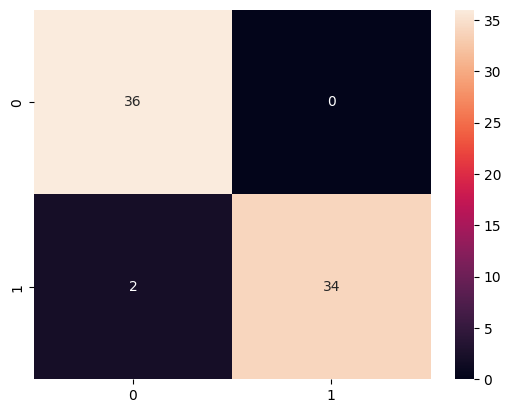

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        36
           1       1.00      0.94      0.97        36

    accuracy                           0.97        72
   macro avg       0.97      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72



# FINE-TUNING

In [36]:
base_model.trainable=True # enable to train the model

In [37]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x78bc6b1fa0e0> True
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x78bc6ada46d0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78bc6b1fa0b0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x78bc6ada4ee0> True
<keras.src.layers.core.activation.Activation object at 0x78bc6ada5f60> True
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x78bc6ada6500> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78bc6ada7490> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78bc6ada73d0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x78bc6a1954e0> True
<keras.src.layers.core.activation.Activation object at 0x78bc6a1972e0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x78bc6a196f50> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 

In [38]:
fine_tuning_at = 140  # layer 140 - layer 175 layers will be free to train

for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable=False

In [40]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')

In [41]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
36/36 [==============================] - 18s 147ms/step - loss: 3.1080 - accuracy: 0.5694
Epoch 2/50
36/36 [==============================] - 7s 199ms/step - loss: 0.5623 - accuracy: 0.6736
Epoch 3/50
36/36 [==============================] - 5s 147ms/step - loss: 0.3573 - accuracy: 0.8576
Epoch 4/50
36/36 [==============================] - 9s 242ms/step - loss: 0.3101 - accuracy: 0.9097
Epoch 5/50
36/36 [==============================] - 9s 243ms/step - loss: 0.4106 - accuracy: 0.8368
Epoch 6/50
36/36 [==============================] - 6s 175ms/step - loss: 0.4271 - accuracy: 0.8507
Epoch 7/50
36/36 [==============================] - 5s 133ms/step - loss: 0.2778 - accuracy: 0.8958
Epoch 8/50
36/36 [==============================] - 7s 190ms/step - loss: 0.2248 - accuracy: 0.9062
Epoch 9/50
36/36 [==============================] - 5s 136ms/step - loss: 0.3180 - accuracy: 0.8889
Epoch 10/50
36/36 [==============================] - 5s 134ms/step - loss: 0.1504 - accuracy: 0.937

# RE-EVALUATE

In [42]:
predictions = network.predict(test_dataset)
predictions

72/72 [==============================] - 3s 17ms/step


array([[9.99999166e-01, 7.81219057e-07],
       [1.00000000e+00, 1.02718868e-10],
       [1.00000000e+00, 5.25877338e-28],
       [1.00000000e+00, 1.83380198e-16],
       [1.00000000e+00, 6.80386891e-16],
       [1.00000000e+00, 6.50797904e-09],
       [9.99999166e-01, 8.75987496e-07],
       [1.00000000e+00, 2.82370183e-13],
       [1.00000000e+00, 6.86343603e-12],
       [1.00000000e+00, 7.32103226e-26],
       [1.00000000e+00, 6.38375800e-13],
       [9.99986768e-01, 1.32696650e-05],
       [1.00000000e+00, 5.56630688e-08],
       [9.99008715e-01, 9.91324428e-04],
       [1.00000000e+00, 6.47867631e-20],
       [1.00000000e+00, 3.65226545e-18],
       [1.00000000e+00, 1.56715558e-27],
       [1.00000000e+00, 2.01051622e-14],
       [1.00000000e+00, 4.69943779e-16],
       [1.00000000e+00, 8.57662279e-15],
       [1.00000000e+00, 1.36904166e-09],
       [1.00000000e+00, 6.52794062e-14],
       [1.00000000e+00, 7.64557935e-20],
       [1.00000000e+00, 2.32394515e-21],
       [1.000000

In [43]:
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1])

In [44]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes,predictions)

0.9027777777777778

<Axes: >

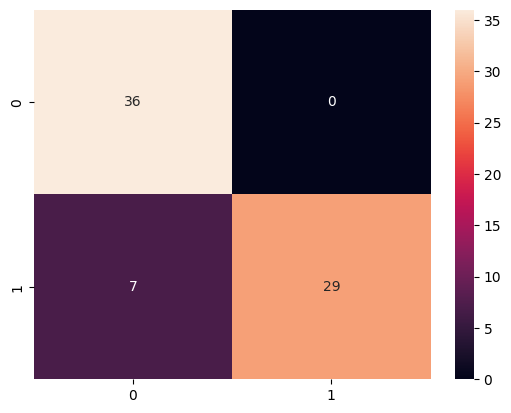

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

# SAVE THE MODEL

In [47]:
model_json = network.to_json()
with open('network.json', 'w') as json_file:
  json_file.write(model_json)

In [48]:
from keras.models import save_model
network_saved = save_model(network, './content/weights.hdf5')

<ipython-input-48-911f2f028b71>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, './content/weights.hdf5')


In [49]:
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "registered_name": null, "build_config": {"input_shape": [null, 256, 256, 3]}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initia

In [52]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/content/weights.hdf5')
network_loaded.compile(loss='categorical_lossentropy', optimizer='Adam', metrics=['accuracy'])
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

# CLASSIFYING AN IMAGE

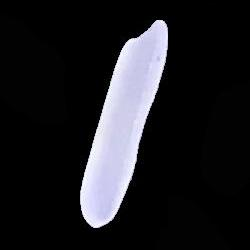

In [54]:
img = cv2.imread('/content/Basmati/basmati (9810).jpg')
cv2_imshow(img)

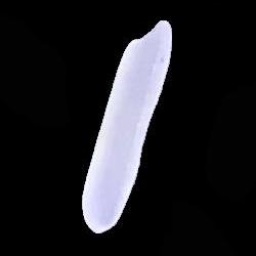

In [56]:
img = cv2.resize(img, (256,256))
cv2_imshow(img)

In [57]:
img = img / 255   # normalize the img, range from 0-1
img.shape

(256, 256, 3)

In [58]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [59]:
result = network_loaded(img)
result

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.0000000e+00, 2.0720394e-14]], dtype=float32)>

In [60]:
result = np.argmax(result)
result  # correct

0

In [61]:
test_dataset.class_indices

{'basmati_test': 0, 'jasmine_test': 1}